In [2]:
source("./libs.R")

## data load

In [4]:
##------------------------------------------------------------
## inputs
##------------------------------------------------------------

input.chromVar.res.list <- readRDS(file = "../dat/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z
input.umap.res <- fread('../dat/1908/Islet_123.MNN_corrected.cluster_labels.filt.txt',header = T)
input.chromVar.jaspar.var <- fread("../dat/1908/output.jaspar.var.res.abcd.csv")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 600 rows [5, 18, 19, 50, 81, 114, 128, 147, 169, 175, 176, 190, 209, 250, 260, 345, 353, 376, 389, 413, ...].”

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
Islet3-fresh_CTGAAGCTTGCAGCTACTCTCTATTATAGCCT,6.029433,-3.429818,beta_2,beta,2,4.520863,4.152013,0,0,1


[1] 14239    11

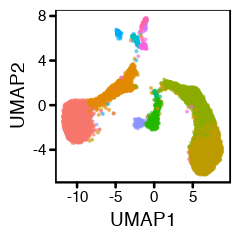

In [5]:
options(repr.plot.width = 2, repr.plot.height = 2)
# filter unkonwn
input.umap.res <- input.umap.res %>% separate(cluster, into = c("cell_type_overall", 
    "subtype"), remove = F)
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr() + theme(legend.position = "none")

In [6]:
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z

table(input.umap.res %>% filter(barcodes %in% colnames(input.chromVar.jaspar.z)[-1]) %>% 
    pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))


      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7108         709         136         113         205 
      glial      immune    stellate 
         34          58         134 


      alpha        beta       delta endothelial    exocrine       gamma 
       5594        7170         718         157         131         206 
      glial      immune    stellate 
         39          71         153 

In [15]:
input.chromVar.jaspar.z.agg <- melt(data.table(assays(input.chromVar.res.list$dev)$z, 
    keep.rownames = T), id = "rn", variable.name = "barcodes", value.name = "zval")
input.chromVar.jaspar.z.agg %>% head(1)

input.chromVar.jaspar.z.agg %>% nrow
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg %>% inner_join(input.umap.res) %>% 
    separate(rn, into = c("id", "name"), sep = "_")
input.chromVar.jaspar.z.agg %>% nrow

input.chromVar.jaspar.z.agg %>% head(1)
input.chromVar.jaspar.z.agg %>% select(barcodes, cell_type_overall) %>% unique %>% 
    pull(cell_type_overall) %>% table

range(input.chromVar.jaspar.z.agg$zval)

rn,barcodes,zval
MA0025.1_NFIL3,Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,-0.3430543


[1] 5692728

Joining, by = "barcodes"
Warning message:
“Column `barcodes` joining factor and character vector, coercing into character vector”

[1] 5416738

id,name,barcodes,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
MA0025.1,NFIL3,Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,-0.3430543,6.975175,-3.232226,beta_1,beta,1,3.694693,3.384174,1,0,0


.
      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7109         709         136         113         205 
      glial      immune    stellate 
         34          58         134 

[1] -17.90770  35.45968

In [70]:
ttest.res<- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1S_one_vs_one.csv") 
ttest.res%>%head(1)
dim(ttest.res)
ttest.res%>%select(motif,test)%>%unique%>%nrow

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id,family.id,family.name,class.id,class.name,superclass.id,superclass.name
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


[1] 790  19

[1] 772

## functions

In [10]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z, 
    umap.res = input.umap.res, rescale = F, cls, bks = c(-4, 0, 4), ...) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    tmp <- tmp %>% mutate(zval = ifelse(zval > bks[3], bks[3], ifelse(zval < bks[1], 
        bks[1], zval)))
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        shape = 16, ...) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10, family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”

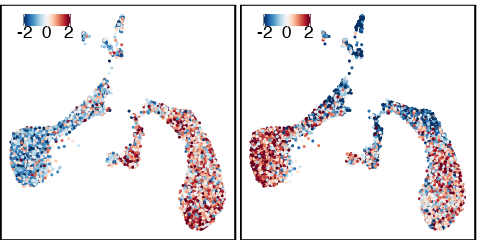

In [11]:
options(repr.plot.width = 4, repr.plot.height = 2)

ps <- lapply(c("PDX1", "FOXA1"), fun.plot.project.motif, bks = c(-2, 0, 
    2),size=.25,cls=rev(brewer.pal(n = 11, "RdBu")))
names(ps) <- c("PDX1", "FOXA1")
ggarrange(plotlist = ps, ncol = 2)

## beta vs delta

In [12]:
cols.celltype["beta"] = rgb(t((col2rgb(cols.celltype["beta_1"]) + col2rgb(cols.celltype["beta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["alpha"] = rgb(t((col2rgb(cols.celltype["alpha_1"]) + col2rgb(cols.celltype["alpha_2"]))/2), 
    maxColorValue = 255)
cols.celltype["delta"] = rgb(t((col2rgb(cols.celltype["delta_1"]) + col2rgb(cols.celltype["delta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["endothelial"] = rgb(t((col2rgb(cols.celltype["endothelial_1"]) + col2rgb(cols.celltype["endothelial_2"]))/2), 
    maxColorValue = 255)

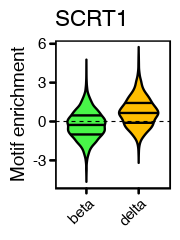

In [25]:
plotViolin <- function(motif = m, test_celltypes = celltype.test) {
    pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
        test_celltypes)
    pd$cell_type_overall <- factor(pd$cell_type_overall,levels = test_celltypes)
    ggviolin(pd, x = "cell_type_overall", remove = T, width = 0.75, y = "zval", size = 0.5, 
        shape = 16, draw_quantiles = c(0.25, 0.5, 0.75), fill = "cell_type_overall", 
        ylab = "Motif enrichment") + theme_pubr() + ggtitle(motif) + geom_hline(yintercept = 0, 
        linetype = 2, size = 0.25) + theme(legend.position = "none", axis.text.x = element_text(angle = 45, 
        hjust = 1), axis.title.x = element_blank()) + scale_fill_manual(values = cols.celltype)
    
}
options(repr.plot.width = 1.5, repr.plot.height = 2)
plotViolin("SCRT1", c("beta", "delta"))

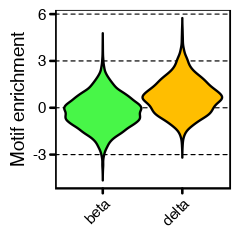

In [49]:
plotViolin2 <- function(motifs, test_celltypes = celltype.test) {
    pd <- input.chromVar.jaspar.z.agg %>% filter(name %in% motifs, cell_type_overall %in% 
        test_celltypes)
    pd$cell_type_overall <- factor(pd$cell_type_overall, levels = test_celltypes)
    pd$name <- factor(pd$name, levels = motifs)
    ggviolin(pd, x = "cell_type_overall", remove = T, width = 1, y = "zval", size = 0.5, 
        shape = 16, fill = "cell_type_overall", ylab = "Motif enrichment") + theme_pubr() + 
        theme(legend.position = "none", panel.grid.major.y = element_line(linetype = 2, 
            size = 0.25), axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank()) + 
        scale_fill_manual(values = cols.celltype)
    
}
options(repr.plot.width = 2, repr.plot.height = 2)
plotViolin2("SCRT1", c("beta", "delta"))

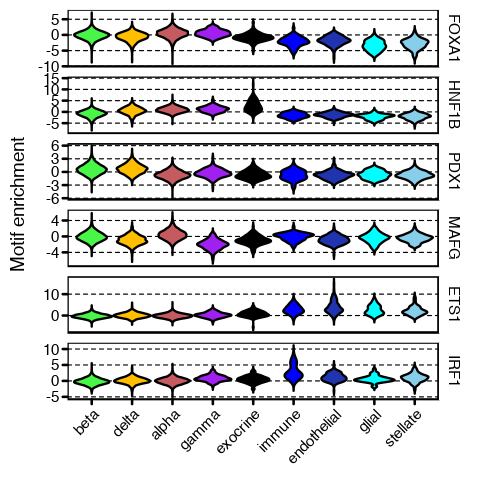

In [51]:
options(repr.plot.width = 4, repr.plot.height = 4)

plotViolin2(c('FOXA1','HNF1B','PDX1','MAFG',"ETS1",'IRF1'), c("beta", "delta", "alpha", "gamma", "exocrine", "immune", "endothelial", 
    "glial", "stellate"))+ 
        facet_grid(name~.,scales = 'free_y')

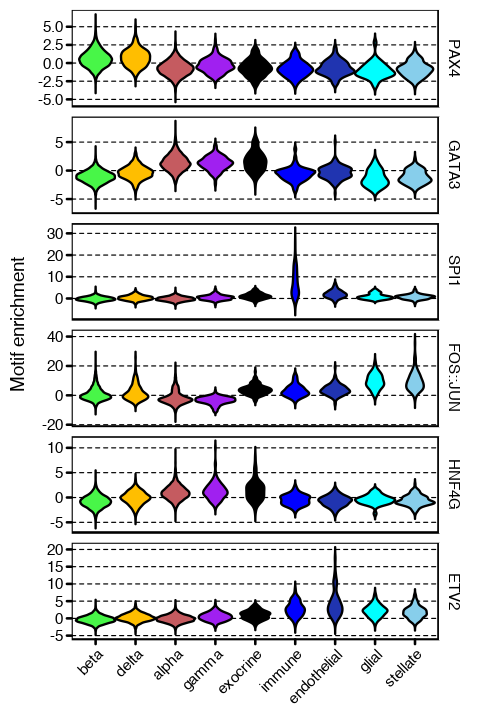

In [56]:
options(repr.plot.width = 4, repr.plot.height = 6)

plotViolin2(c("PAX4", "GATA3", "SPI1", "FOS::JUN", "HNF4G", "ETV2"), c("beta", "delta", 
    "alpha", "gamma", "exocrine", "immune", "endothelial", "glial", "stellate")) + 
    facet_grid(name ~ ., scales = "free_y")

In [59]:
head(ttest.res,1)
input.chromVar.jaspar.z.agg%>%head(1)

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id,family.id,family.name,class.id,class.name,superclass.id,superclass.name
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


id,name,barcodes,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
MA0025.1,NFIL3,Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,-0.3430543,6.975175,-3.232226,beta_1,beta,1,3.694693,3.384174,1,0,0


In [64]:
top_motifs[top_motifs%>%duplicated]

[1] "MAF::NFE2"   "FOS::JUN"    "BATF::JUN"   "TAL1::TCF3"  "NR1H2::RXRA"
[6] "NFIC::TLX1"

## heatmap

In [75]:
ttest.res<- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1E_one_vs_other.csv") 
ttest.res%>%head(1)
dim(ttest.res)
ttest.res%>%select(motif,test)%>%unique%>%nrow

jaspar.id,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,family.id,family.name,class.id,class.name,superclass.id,superclass.name
MA0490.1,JUNB,9.59733,-0.09048998,2.036859e-37,stellate.vs.other,stellate,other,stellate,4.624868e-36,7.862276e-35,1.1.1,Jun-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


[1] 3555   17

[1] 3474

In [72]:
ttest.res %>% head(1)
ttest.res.2 <- ttest.res %>% select(motif, test, padj,enrichedIn) %>% unique

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id,family.id,family.name,class.id,class.name,superclass.id,superclass.name
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


In [93]:
sapply(ttest.res %>% arrange(test) %>% pull(test) %>% unique, function(ntest) ttest.res %>% 
    filter(test == ntest, padj < 0.001 & mean_x > 0.5 & mean_y < 0) %>% pull(motif) %>% 
    unique %>% length)
top_motifs.list <- sapply(ttest.res %>% arrange(test) %>% pull(test) %>% unique, 
    function(ntest) ttest.res %>% filter(test == ntest, padj < 0.001 & mean_x > 0.5 & 
        mean_y < 0) %>% pull(motif) %>% unique)

alpha.vs.other        beta.vs.other       delta.vs.other 
                   8                   28                   60 
endothelial.vs.other    exocrine.vs.other       gamma.vs.other 
                  85                   87                   24 
      glial.vs.other      immune.vs.other    stellate.vs.other 
                  50                   62                   98

In [121]:
pd <- input.chromVar.jaspar.z.agg %>% filter(name %in% top_motifs, cell_type_overall %in% 
    c("alpha", "beta", "delta", "gamma")) %>% select(barcodes, name, zval, cell_type_overall) %>% 
    unique %>% mutate(motif = as.numeric(factor(name, levels = top_motifs)))
dim(pd)
# pd$zval[pd$zval > max_z] <- max_z pd$zval[pd$zval < -max_z] <- -max_z

tmp <- pd %>% select(barcodes, cell_type_overall) %>% unique() %>% arrange(cell_type_overall)
# dim(tmp %>% mutate(barcodes))

pd <- pd %>% mutate(barcodes = as.numeric(factor(barcodes, levels = tmp$barcodes)))

pd %>% group_by(name) %>% summarise(minz = quantile(zval, 
    0.01) %>% as.numeric, maxz = quantile(zval, 0.99) %>% as.numeric)%>%head(2)

[1] 1125314       5

name,minz,maxz
ALX3,-2.547193,2.966423
BARX1,-2.366885,2.811605


[1] "GATA3"        "GATA2"        "GATA5"        "HNF4G"        "HNF1B"       
 [6] "HNF1A"        "GATA1::TAL1"  "FOXB1"        "FOS::JUN"     "JUNB"        
[11] "FOSL1"        "FOSL2"        "JUND"         "JUN(var.2)"   "FOS"         
[16] "NFE2"         "DLX6"         "LHX2"         "EMX2"         "NOTO"        
[21] "PAX4"         "BATF::JUN"    "NKX6-2"       "EMX1"         "GSX1"        
[26] "PDX1"         "JDP2"         "MAF::NFE2"    "NKX6-1"       "LHX6"        
[31] "EVX2"         "VAX1"         "VAX2"         "LBX1"         "MEOX1"       
[36] "POU6F2"       "POU6F1"       "RAX"          "HOXA2"        "HESX1"       
[41] "ESX1"         "SCRT1"        "HOXB3"        "GBX1"         "HOXB2"       
[46] "ELF5"         "GBX2"         "MIXL1"        "MEOX2"        "GSX2"        
[51] "ISX"          "LHX9"         "RAX2"         "SHOX"         "PRRX1"       
[56] "MNX1"         "LMX1A"        "LMX1B"        "UNCX"         "BARX1"       
[61] "ISL2"         "SCRT2"        "ALX3"         "PHOX2A"       "EVX1"        
[66] "LBX2"         "VSX1"         "VSX2"         "CTCF"         "EHF"         
[71] "IRF1"         "IRF2"         "STAT1::STAT2" "NFIC::TLX1"   "ELF3"        
[76] "PRDM1"        "IRF8"         "IRF7"         "IRF9"         "MEIS1"       
[81] "SPIC"         "ELF4"         "FOXA1"

[1] 1125314       5


alpha  beta delta gamma 
 5535  7109   709   205 


Joining, by = "name"


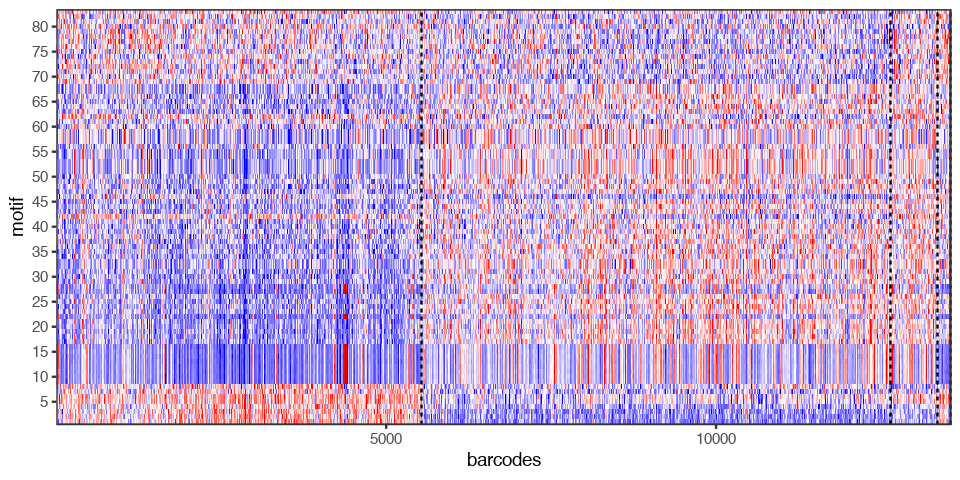

In [122]:
options(repr.plot.width = 8, repr.plot.height = 4)
testt = "alpha.vs.other"
fdr_th = 0.001
# max_z = 5
(top_motifs <- do.call(c, top_motifs.list[c(1:3, 6)]) %>% unique)

pd <- input.chromVar.jaspar.z.agg %>% filter(name %in% top_motifs, cell_type_overall %in% 
    c("alpha", "beta", "delta", "gamma")) %>% select(barcodes, name, zval, cell_type_overall) %>% 
    unique %>% mutate(motif = as.numeric(factor(name, levels = top_motifs)))
dim(pd)
# pd$zval[pd$zval > max_z] <- max_z pd$zval[pd$zval < -max_z] <- -max_z

tmp <- pd %>% select(barcodes, cell_type_overall) %>% unique() %>% arrange(cell_type_overall)
# dim(tmp %>% mutate(barcodes))

pd <- pd %>% mutate(barcodes = as.numeric(factor(barcodes, levels = tmp$barcodes)))

print(seps <- table(tmp %>% unique() %>% pull(cell_type_overall)))


ncolor = 5

pd <- pd %>% left_join(pd %>% group_by(name) %>% summarise(minz = quantile(zval, 
    0.01) %>% as.numeric, maxz = quantile(zval, 0.99) %>% as.numeric)) %>% mutate(zval.scaled = ifelse(zval > 
    maxz, 1, ifelse(zval < minz, 0, (zval - minz)/(maxz - minz))))

ggplot(pd, aes(x = barcodes, y = motif)) + geom_raster(aes(fill = zval.scaled)) + 
    geom_vline(xintercept = as.numeric(cumsum(seps)), linetype = 2, size = 0.5) + 
    scale_y_continuous(breaks = seq(0, 150, by = 5)) + coord_cartesian(expand = F) + 
    theme_bw() + theme(legend.position = "none", panel.grid = element_blank()) + 
    scale_fill_gradientn(colors = colorRampPalette(c("blue", "white", "red"))(ncolor), 
        breaks = seq(0, 1, length.out = ncolor))

In [ ]:
pd 

In [126]:
pd%>%filter(motif%in% 10:15,barcodes%in%1:10)

barcodes,name,zval,cell_type_overall,motif,minz,maxz,zval.scaled
1,FOS,5.3257611,alpha,15,-9.016376,14.25751,0.616232933
1,FOSL1,4.5816077,alpha,11,-9.141494,14.45820,0.581494948
1,FOSL2,3.9643255,alpha,12,-9.308698,14.76174,0.551424160
1,JUN(var.2),4.9842224,alpha,14,-8.938431,14.26902,0.599921589
1,JUNB,4.0204322,alpha,10,-9.467957,14.78268,0.556207692
1,JUND,4.3828950,alpha,13,-9.047694,14.72908,0.564861595
2,FOS,-5.2975515,alpha,15,-9.016376,14.25751,0.159785255
2,FOSL1,-4.2075225,alpha,11,-9.141494,14.45820,0.209069320
2,FOSL2,-4.5929421,alpha,12,-9.308698,14.76174,0.195914789
2,JUN(var.2),-4.4726709,alpha,14,-8.938431,14.26902,0.192427830



alpha gamma 
 5535   205 

alpha gamma 
   51    58 


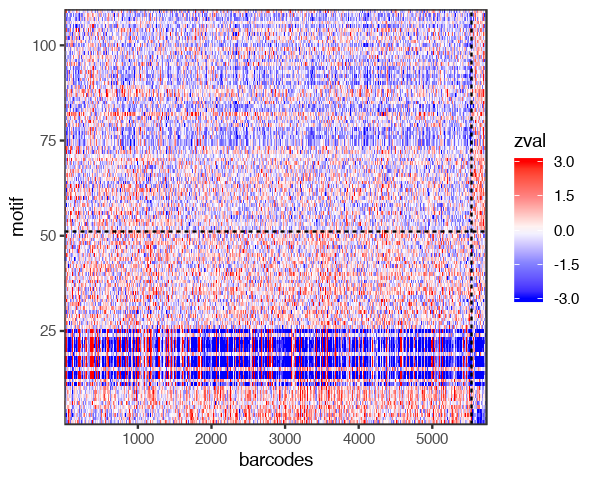

In [74]:
options(repr.plot.width = 5, repr.plot.height = 4)
plotSNmotif <- function(testt = "alpha_vs_gamma", fdr_th = 0.001, max_z = 3, ttest.res = ttest.res.2) {
    top_motifs <- ttest.res %>% filter(padj < fdr_th & test == testt) %>% pull(motif)
    
    cell_types <- unlist(strsplit(testt, "_vs_"))
    pd <- input.chromVar.jaspar.z.agg %>% filter(name %in% top_motifs & cell_type_overall %in% 
        cell_types) %>% select(barcodes, name, zval, cell_type_overall) %>% mutate(motif = as.numeric(factor(name, 
        levels = top_motifs)))
    dim(pd)
    pd$zval[pd$zval > max_z] <- max_z
    pd$zval[pd$zval < -max_z] <- -max_z
    
    tmp <- pd %>% select(barcodes, cell_type_overall) %>% unique() %>% arrange(cell_type_overall)
    # dim(tmp %>% mutate(barcodes))
    
    pd <- pd %>% mutate(barcodes = as.numeric(factor(barcodes, levels = tmp$barcodes)))
    
    print(seps <- table(tmp %>% unique() %>% pull(cell_type_overall)))
    
    print(seps.motif <- table(ttest.res %>% filter(padj < fdr_th & test == testt) %>% 
        pull(enrichedIn)))
    
    ncolor = 5
    ggplot(pd, aes(x = barcodes, y = motif)) + geom_raster(aes(fill = zval)) + geom_hline(yintercept = as.numeric(cumsum(seps.motif))[1], 
        linetype = 2, size = 0.5) + geom_vline(xintercept = as.numeric(cumsum(seps))[1], 
        linetype = 2, size = 0.5) + coord_cartesian(expand = F) + theme_bw() + theme(panel.grid = element_blank()) + 
        scale_fill_gradientn(colors = colorRampPalette(c("blue", "white", "red"))(ncolor), 
            breaks = seq(-3, 3, length.out = ncolor))
}

 plotSNmotif(testt = "alpha_vs_gamma", fdr_th = 0.001)

In [3]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggthemes_4.0.1              extrafont_0.17             
 [3] ggdendro_0.1-20             chromVAR_1.2.0             
 [5] rlist_0.4.6.1               cluster_2.0.7-1            
 [7] matlab_1.0.2                parallelDist_0.2.4         
 [9] RColorBrewer_1.1-2          pheatmap_1.0.10            
[11] ComplexHeatmap_1.20.0       ggpubr_0.2.3               
[13] magrittr_1.5                scales_1.0.0               
[15] forcats_0.3.0               stringr_